In [1]:
import os
import getpass
username = getpass.getuser()
os.environ['MPLCONFIGDIR'] = "~/group/c-xem2/%s/configs/" % username
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#dataModelTable = pd.read_csv('xemModel4.dat',delim_whitespace =True,names=['Z','A','th','Ep','x_bj','Q2','W2','CS','CS_stat','sigTot20','sigQE20','sigIn20','sigTot09','sigQE09','sigIn09'], \
#    dtype={'Z':np.float64,'A':np.float64,'th':np.float64,'Ep':np.float64,'x_bj':np.float64,'Q2':np.float64,'W2':np.float64,'CS':np.float64,'CS_stat':np.float64,'sigTot20':np.float64,'sigQE20':np.float64,'sigIn20':np.float64,'sigTot09':np.float64,'sigQE09':np.float64,'sigIn09':np.float64})
#print(dataModelTable.columns)
#print(dataModelTable)
dataModelTable = pd.read_csv('../output/xemModel14.dat',delim_whitespace =True,names=['Z','A','th','Ep','x_bj','CS','CS_stat','sigTotXEM','sigQEXEM','sigInXEM'], \
    dtype={'Z':np.float64,'A':np.float64,'th':np.float64,'Ep':np.float64,'x_bj':np.float64,'CS':np.float64,'CS_stat':np.float64,'sigTotXEM':np.float64,'sigQEXEM':np.float64,'sigInXEM':np.float64})
#dataModelTable = pd.read_csv('../output/cs_comp/wo_jfac/cs_comp2.out',delim_whitespace =True,names=['Y','A','Z','th','Ep','x_bj','sigInXEM','sigQEXEM','CS','CS_stat'], \
#    dtype={'Y':np.float64,'Z':np.float64,'A':np.float64,'th':np.float64,'Ep':np.float64,'x_bj':np.float64,'CS':np.float64,'CS_stat':np.float64,'sigQEXEM':np.float64,'sigInXEM':np.float64})
#print(dataModelTable.columns)
#print(dataModelTable)


In [5]:
uAngle = np.unique(dataModelTable['th'])
uAngle = np.unique(uAngle[~np.isnan(uAngle)])
uTarget = np.unique(dataModelTable['A'])
uTarget = np.unique(uTarget[~np.isnan(uTarget)])
#print(uAngle,'\n',uTarget)

In [6]:
def mask(df, key, value):
    return df[df[key] == value]
pd.DataFrame.mask = mask

In [7]:
uIdentifier = [(target,angle) for target in uTarget for angle in uAngle]
#print(uIdentifier)

l_crossSections = []
for identifier in uIdentifier:
    tmp_df = dataModelTable.mask('A',identifier[0])
    idx = tmp_df.mask('th',identifier[1]).index
    if len(idx) > 0:
        l_crossSections.append(dataModelTable.loc[idx])
        #print(identifier[0], identifier[1], '\t\t', len(l_crossSections))

In [8]:
def mask2(df, key, value):
    return df[df[key] >= value ]
pd.DataFrame.mask = mask2

In [9]:
l_crossSectionsCut = []
for df in l_crossSections:
    idx = df.mask('x_bj',0).index
    l_crossSectionsCut.append(df.loc[idx])
for df in l_crossSectionsCut:
    df['sigInXEM'] = df['sigInXEM'] / 1000.
    df['sigQEXEM'] = df['sigQEXEM'] * 1000.
    
    df['sigTotXEM'] = df['sigQEXEM'] + df['sigInXEM']
    
    #df['CS_stat'] = df['CS_stat'] * 1000.
    
    df['data_ratioXEM'] = df['CS'] / df['sigTotXEM']


In [10]:
def determineTarg(A):
    if A == 2: return "Deuterium"
    elif A == 3: return "Helium3"
    elif A == 4: return "Helium4"
    elif A == 9: return "Beryllium"
    elif A == 12: return "Carbon"
    elif A == 64: return "Copper"
    elif A == 197: return "Gold"
    else: return "CRAP"

In [13]:
def my_plotter(df):
    xmin=0.3
    xmax=0
    ymin=1e-9
    ymax=1e1
    doLog = True
    fig, ax1 = plt.subplots(2,1,figsize=(10, 2*6))

    if len(df['A']) > 0.:
        targ = determineTarg(df['A'].iloc[0])
        ax1[0].set_title('%s, at %2.0f degrees' % (targ, df['th'].iloc[0]),fontsize=14)
        ax1[1].set_title('%s, at %2.0f degrees' % (targ, df['th'].iloc[0]),fontsize=14)

        xmax = 2. if (df['x_bj'].iloc[-1] + 0.2 > 2.) else df['x_bj'].iloc[-1] + 0.1
        #xmax=3
        if(df['A'].iloc[0] < 3):
            xmax=2
    #Models and Data Comparisons
    df.plot.scatter('x_bj','CS',c='orange',s=56,marker='o',linestyle='None',yerr='CS_stat',xlim=(xmin,xmax),ylim=(ymin,ymax),ax=ax1[0],logy=doLog, label='6GeV Data',fontsize=14)
    df.plot.scatter('x_bj','sigQEXEM',c='tab:red',s=26,marker='v',linestyle='None',xlim=(xmin,xmax),ylim=(ymin,ymax),ax=ax1[0],logy=doLog, label='QE XEM Model',fontsize=14)
    df.plot.scatter('x_bj','sigInXEM',c='tab:blue',s=26,marker='^',linestyle='None',xlim=(xmin,xmax),ylim=(ymin,ymax),ax=ax1[0],logy=doLog, label='DIS XEM Model',fontsize=14)
    df.plot.scatter('x_bj','sigTotXEM',c='indigo',s=16,marker='d',linestyle='None',xlim=(xmin,xmax),ylim=(ymin,ymax),ax=ax1[0],logy=doLog, label='XEM Model',fontsize=14)
    
    #Ratio plot
    df.plot.scatter('x_bj','data_ratioXEM',c='green',marker='o',linestyle='None',xlim=(xmin,xmax),ylim=(0.75,1.25),logy=False,ax=ax1[1])
    ax1[0].legend(fontsize=14)
    ax1[0].set_ylabel("Cross Section",fontsize=14)
    ax1[0].set_xlabel("X",fontsize=14)

    plt.savefig('../output/figures/%s_at_%2.0fdeg.png' % (targ, df['th'].iloc[0]),bbox_inches='tight')
    ax1[1].set_ylabel("Ratio",fontsize=14)
    ax1[0].set_xlabel("X",fontsize=14)

    
    return

78


<ipython-input-13-a471e57995f2>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(2,1,figsize=(10, 2*6))


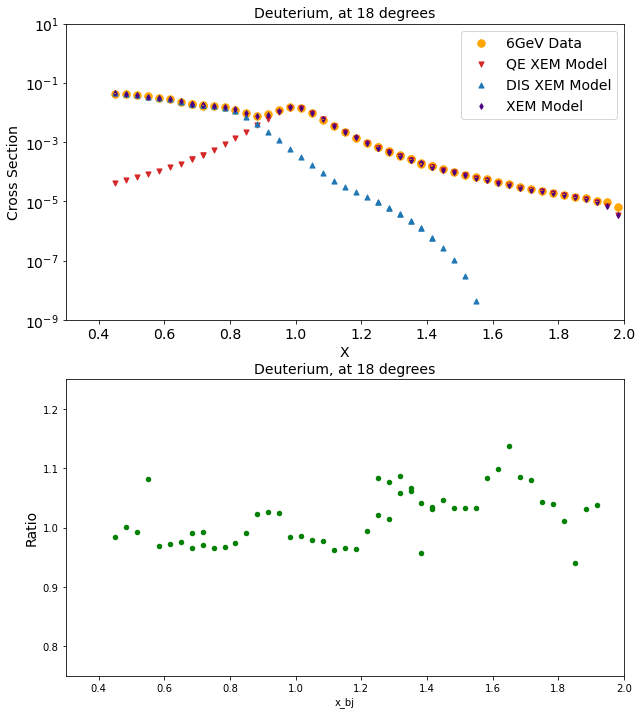

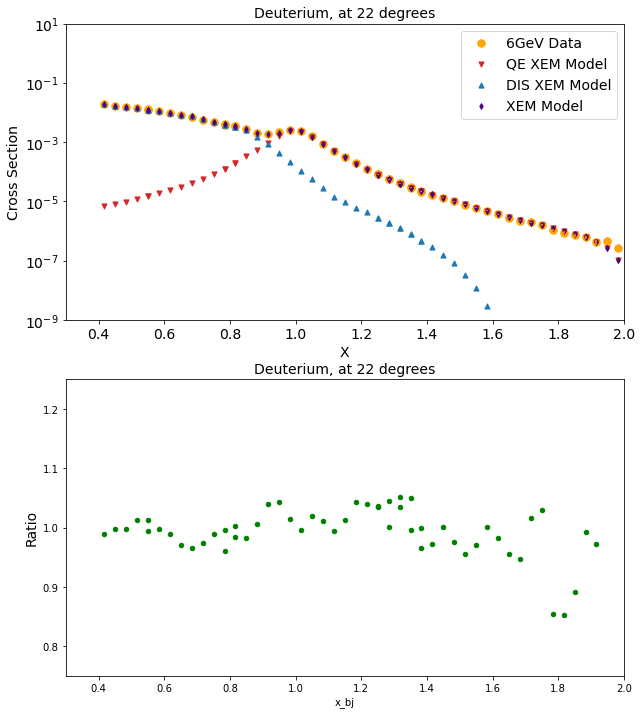

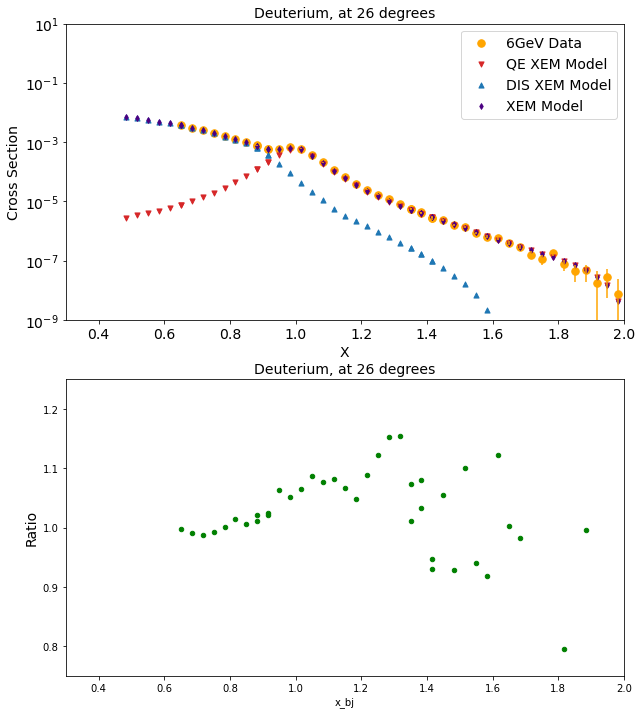

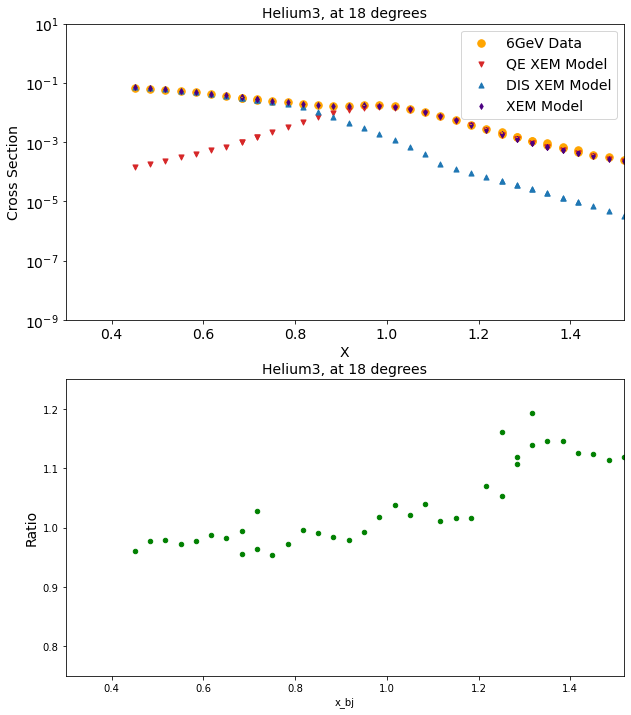

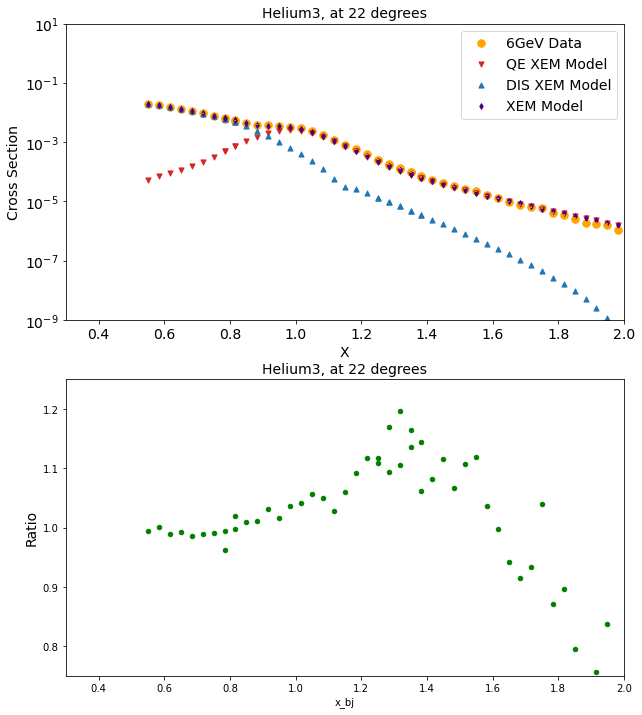

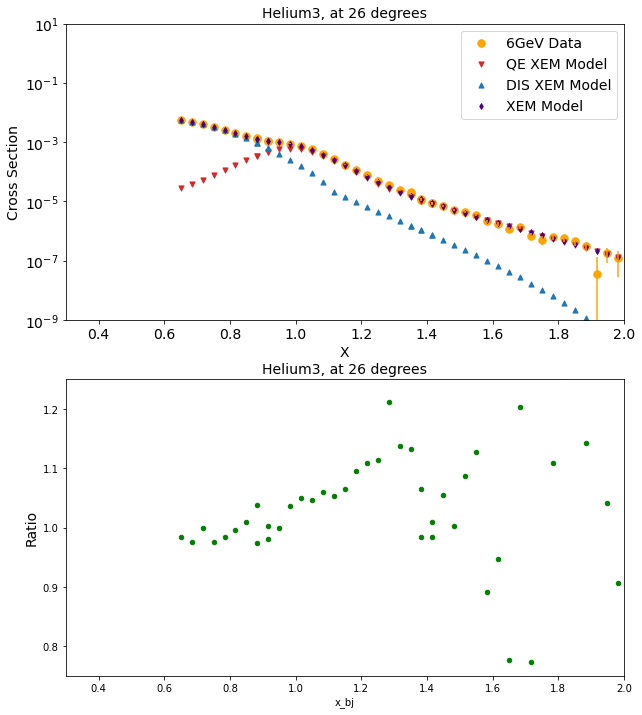

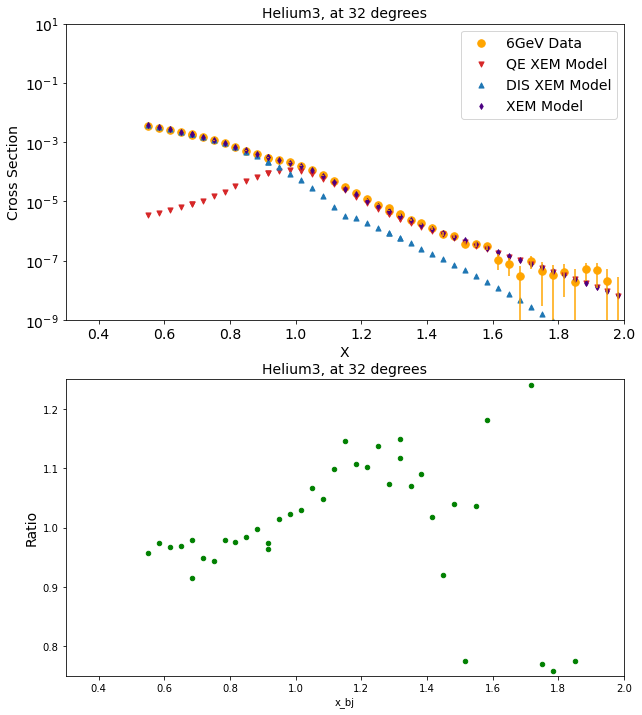

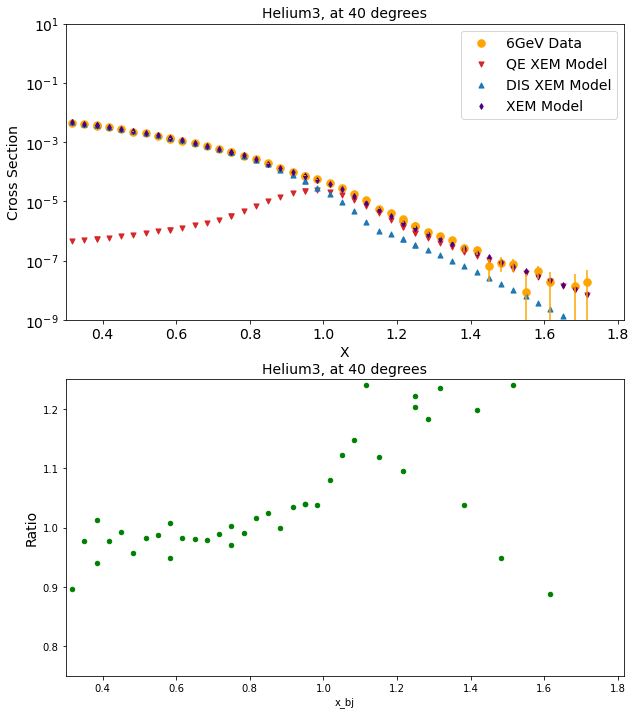

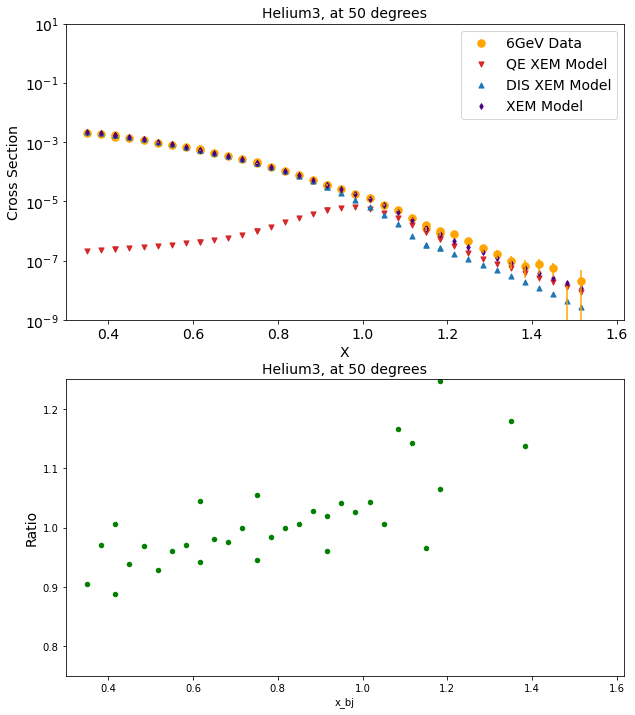

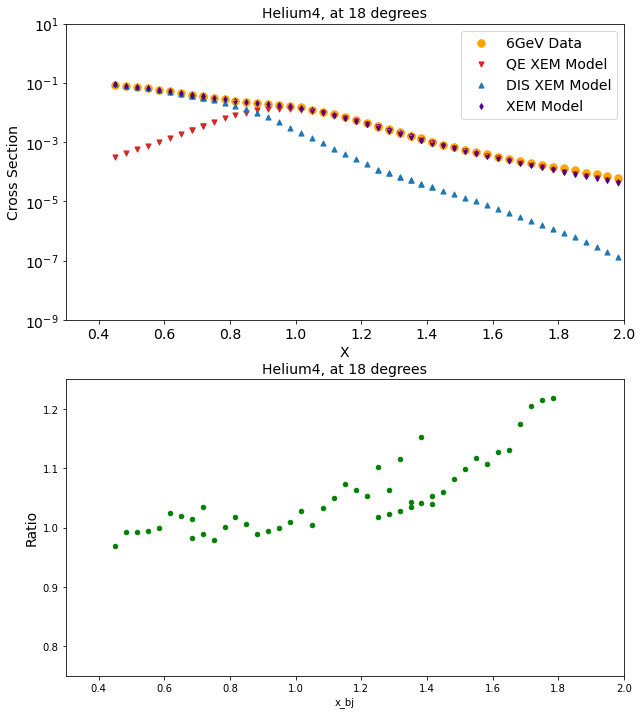

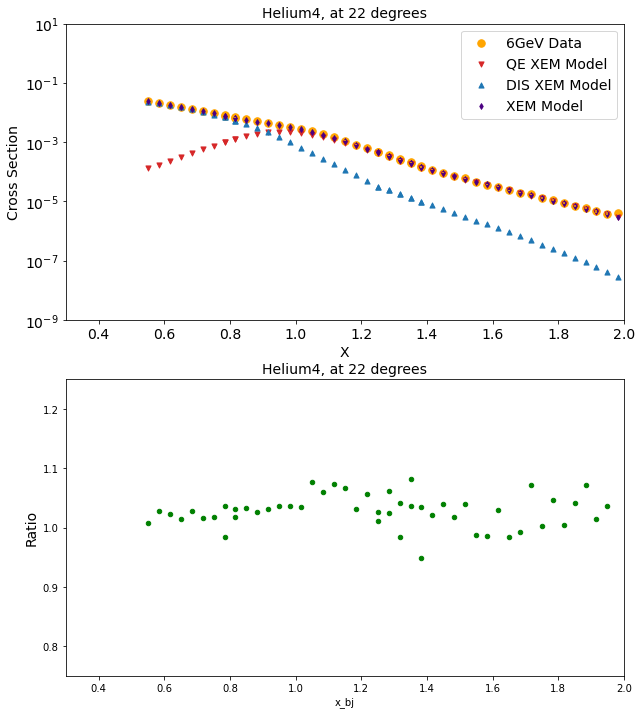

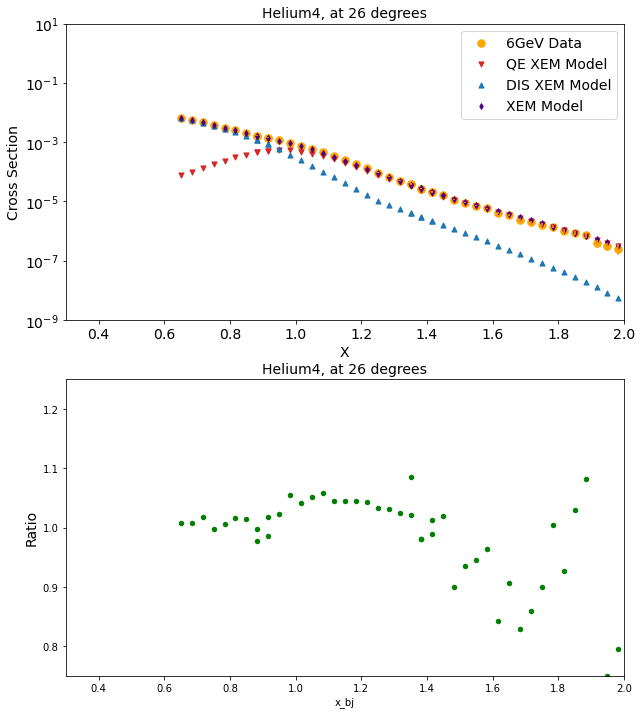

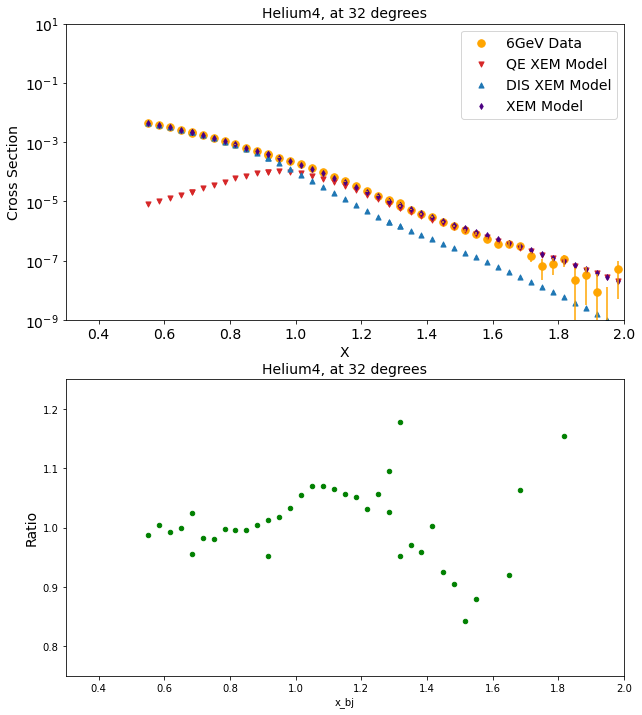

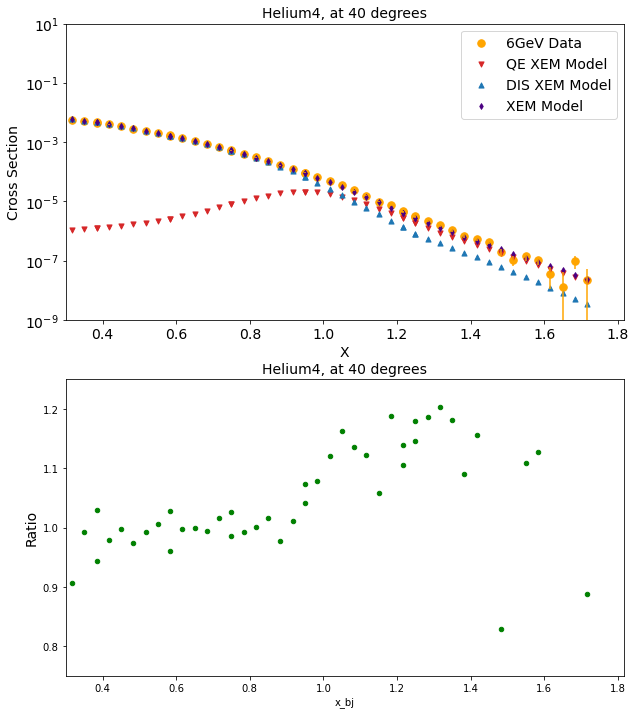

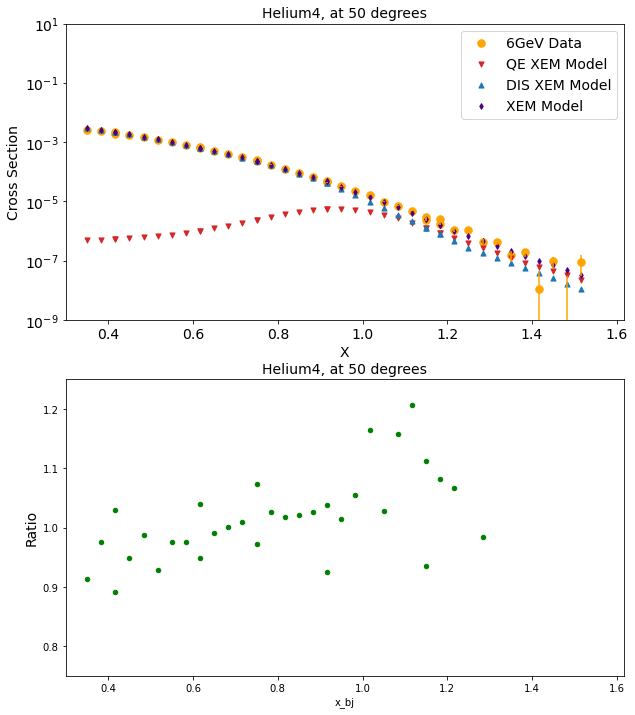

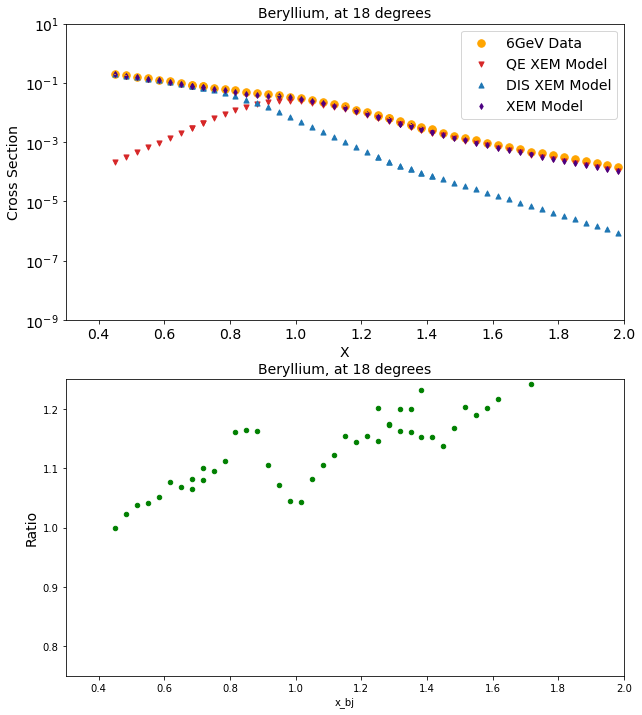

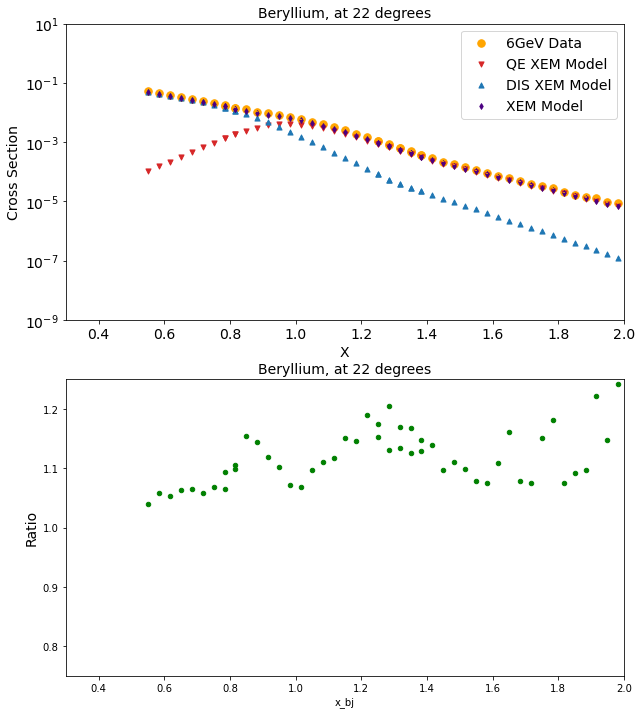

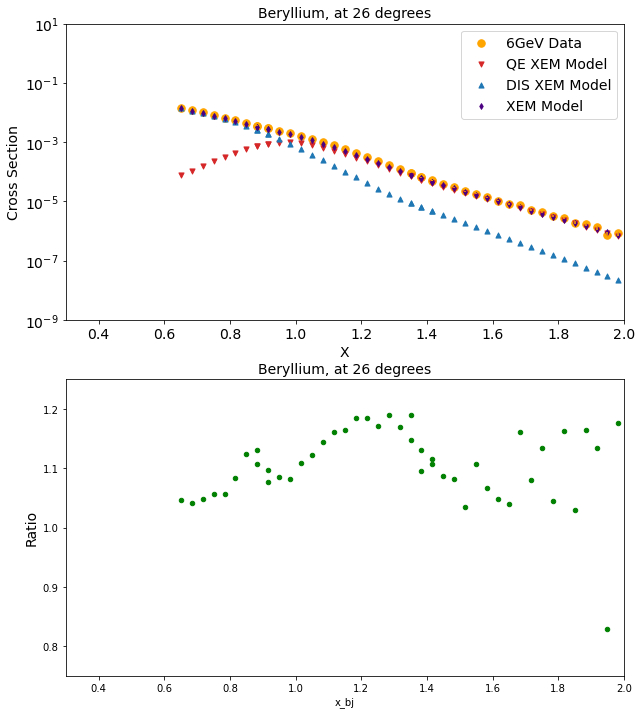

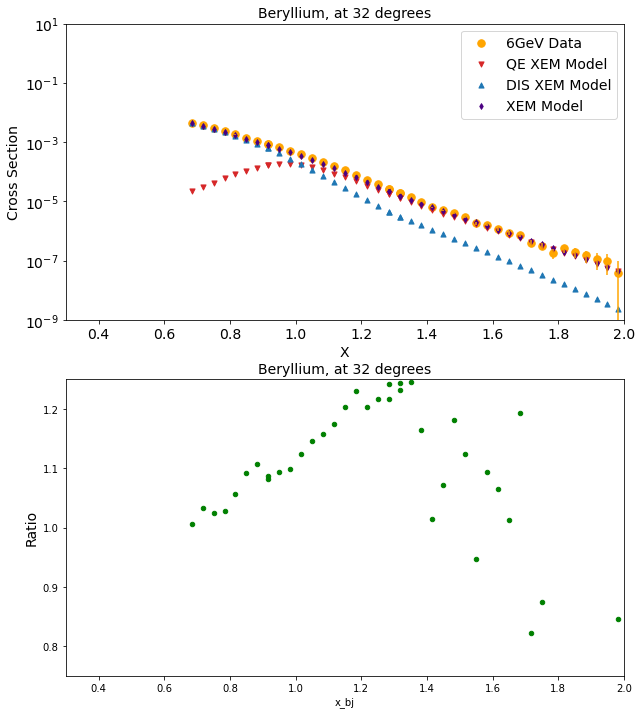

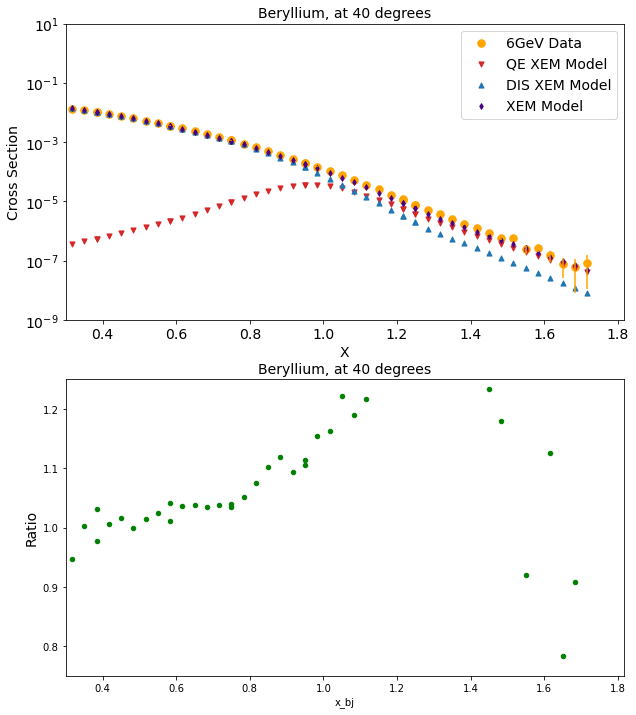

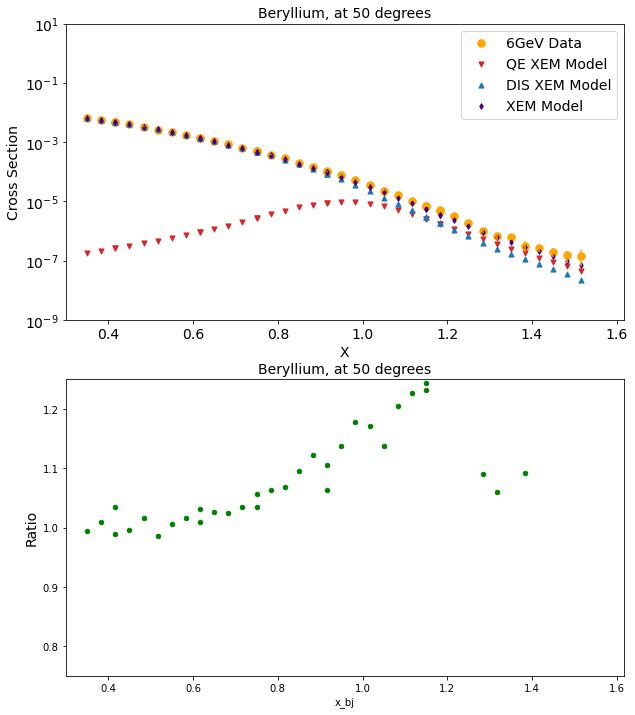

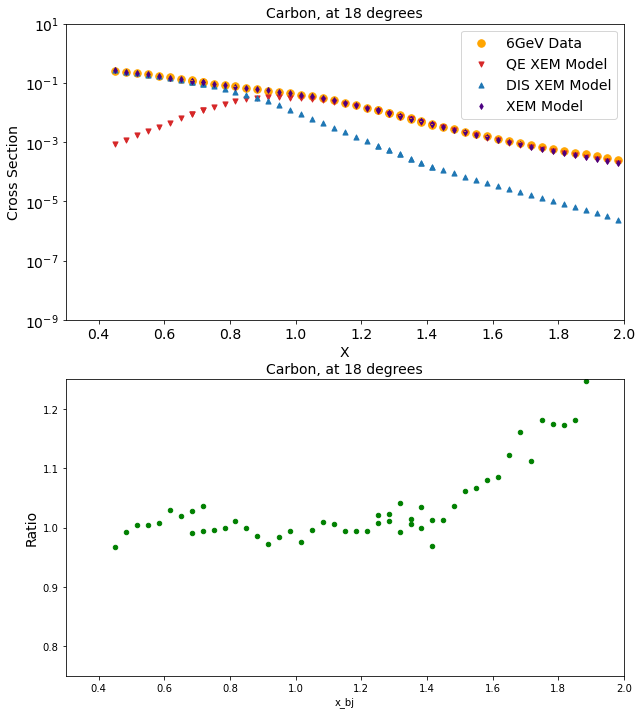

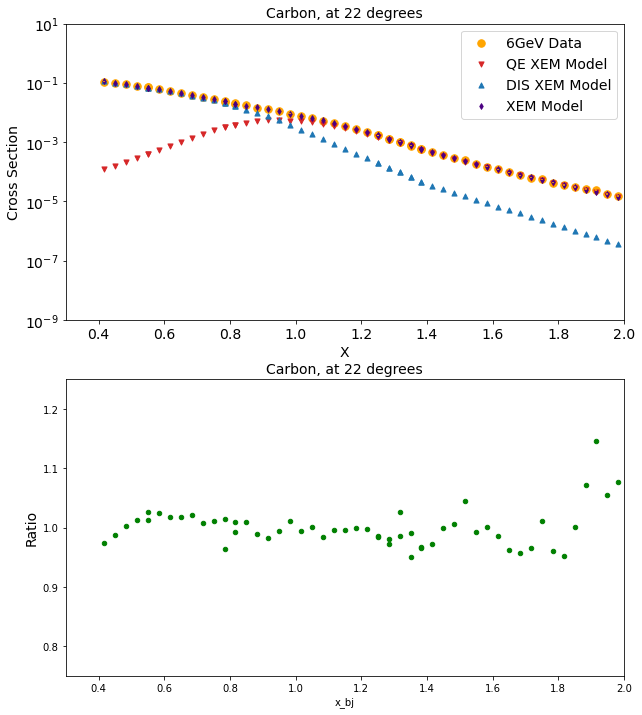

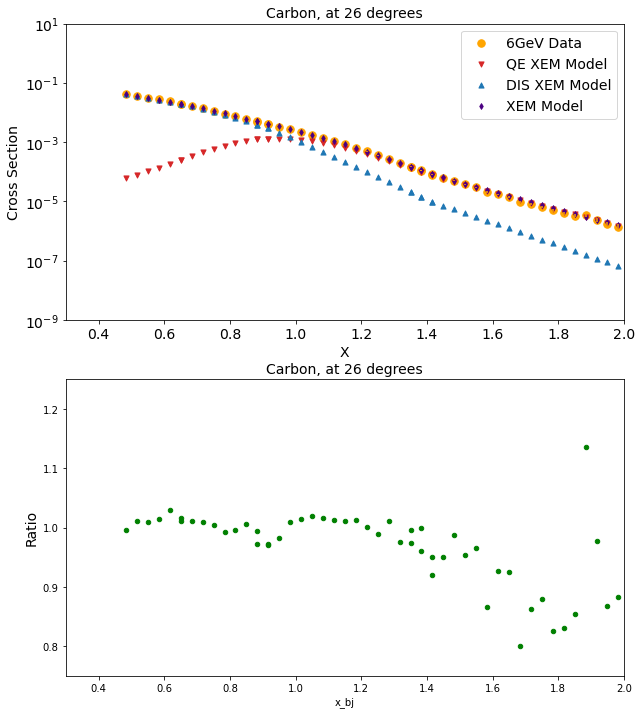

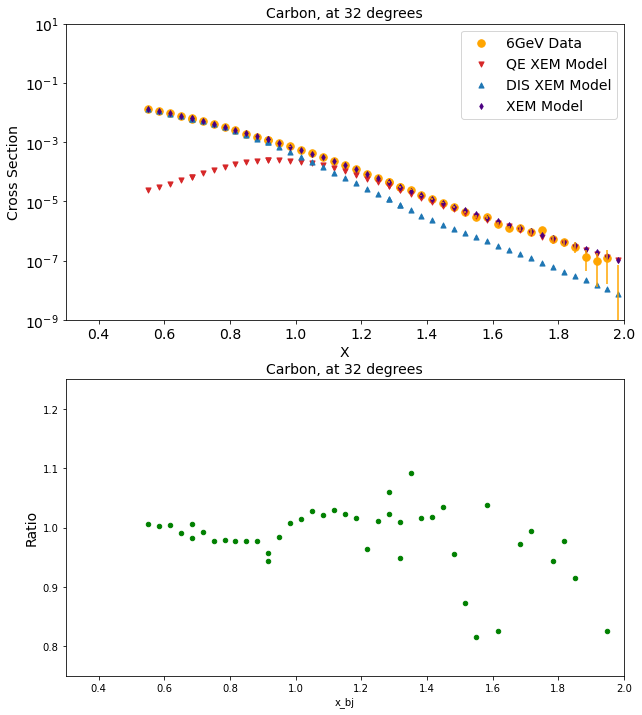

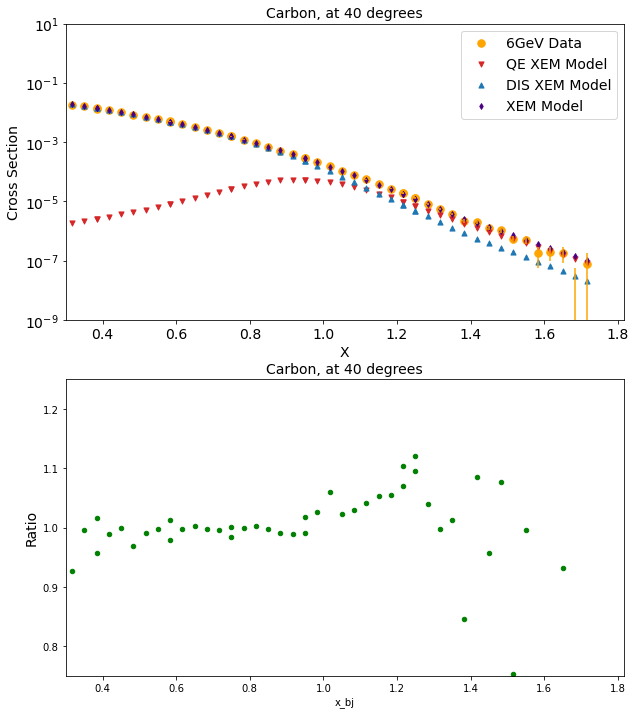

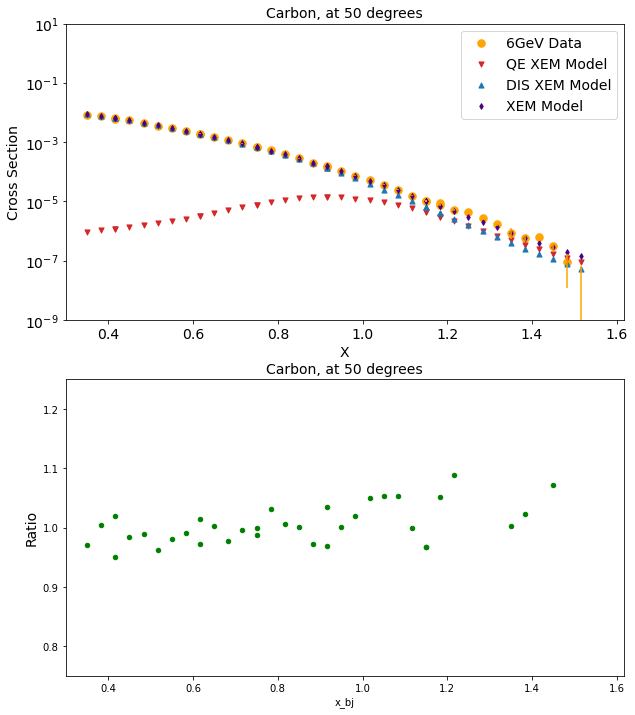

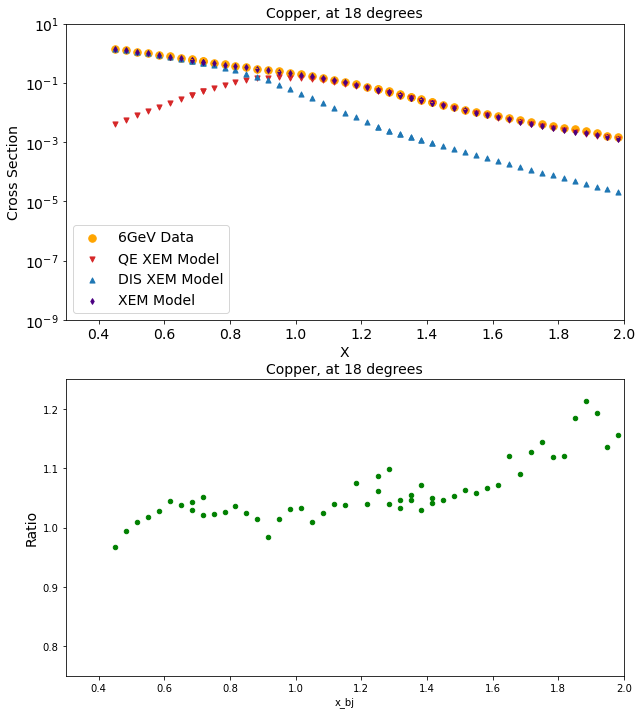

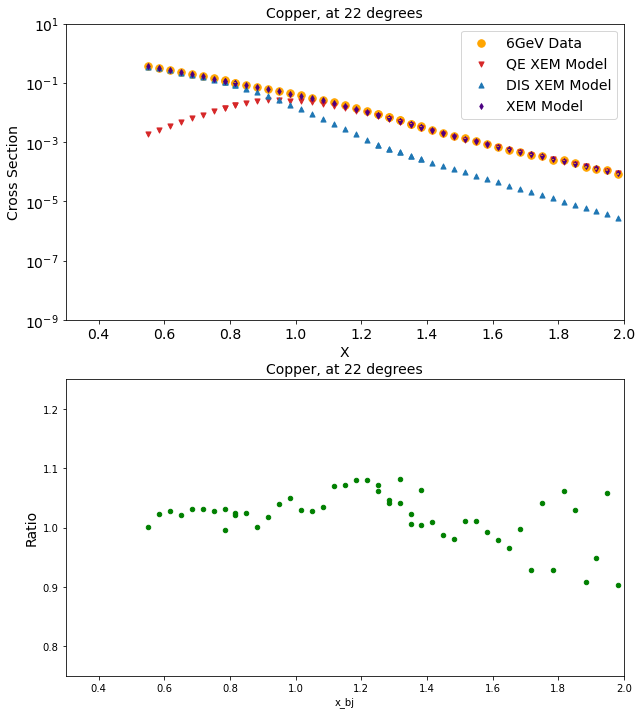

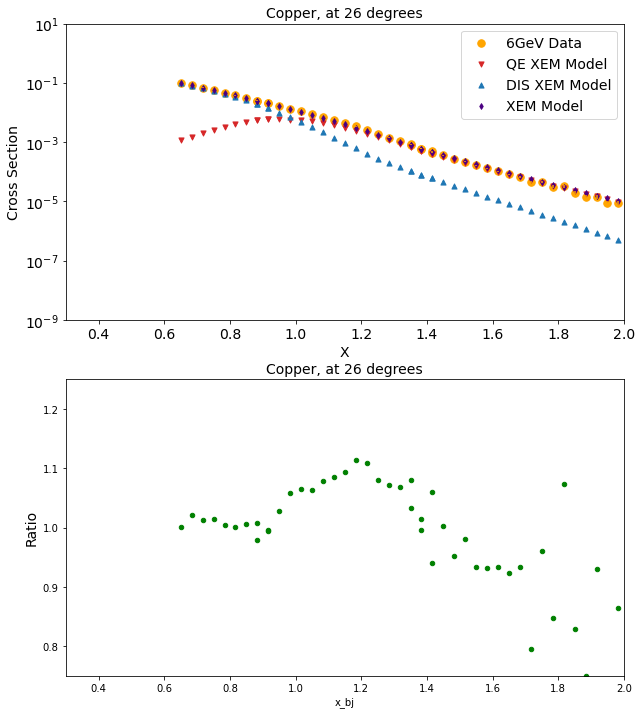

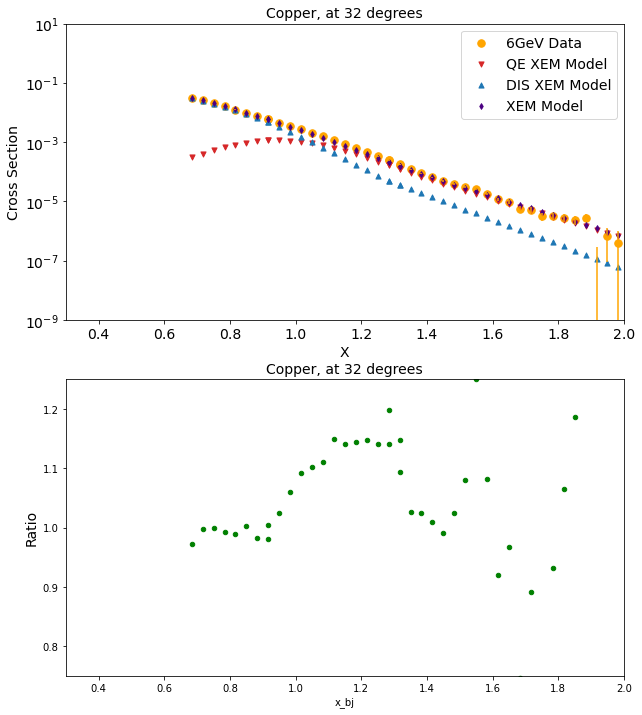

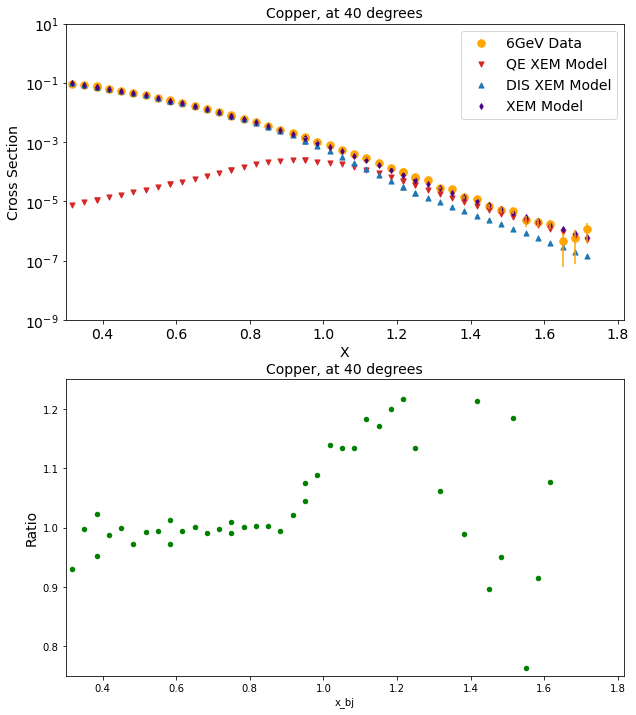

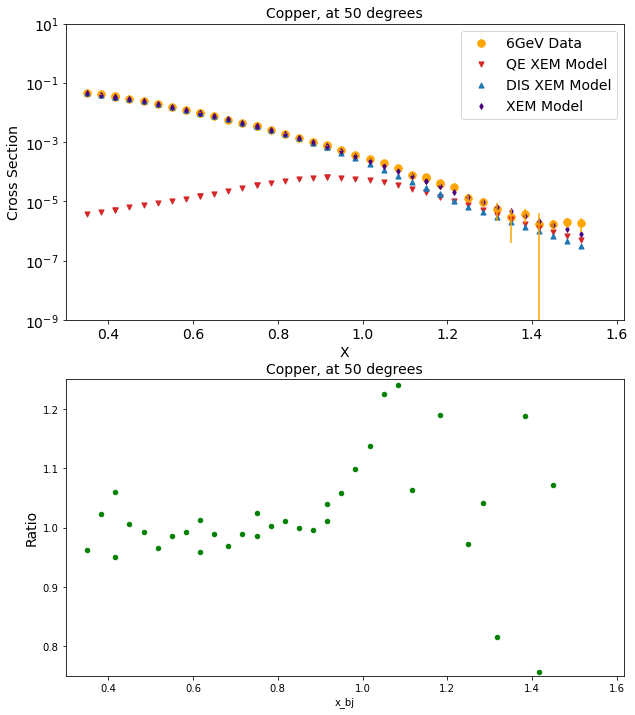

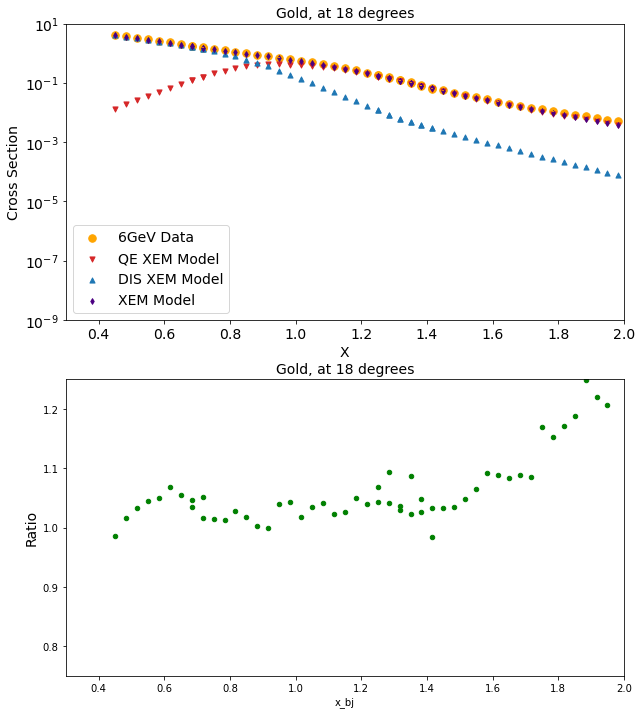

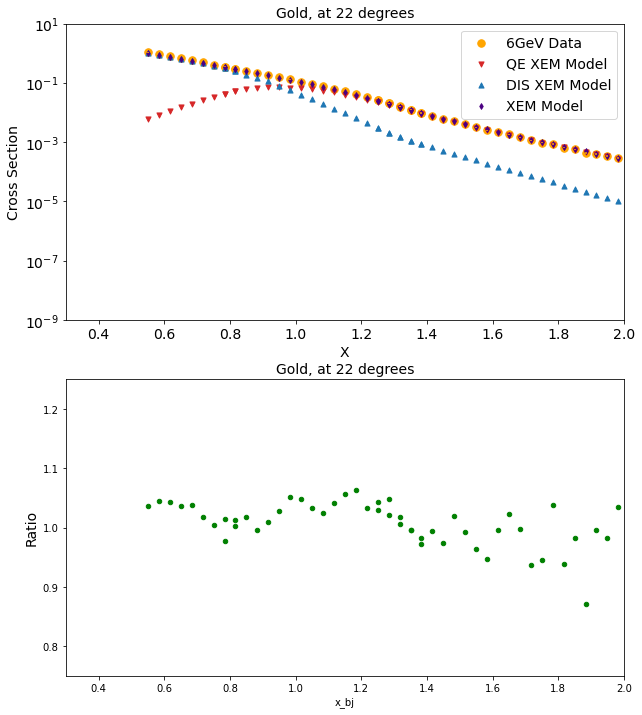

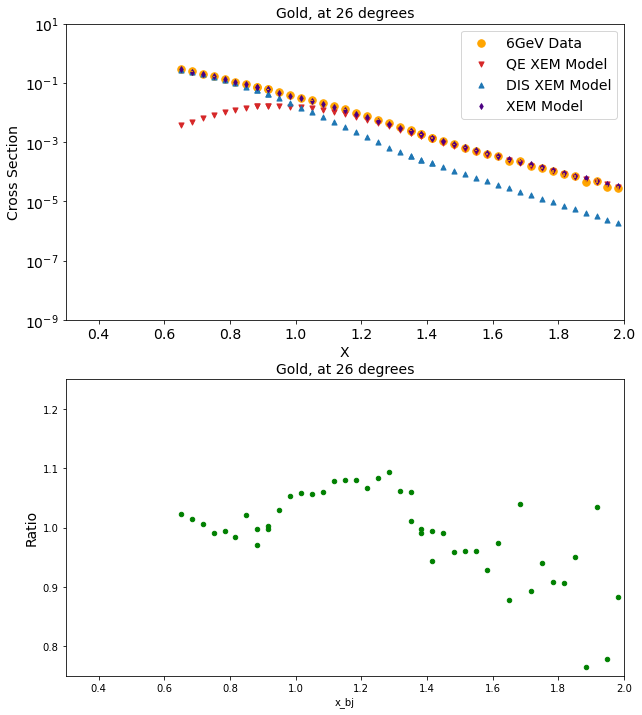

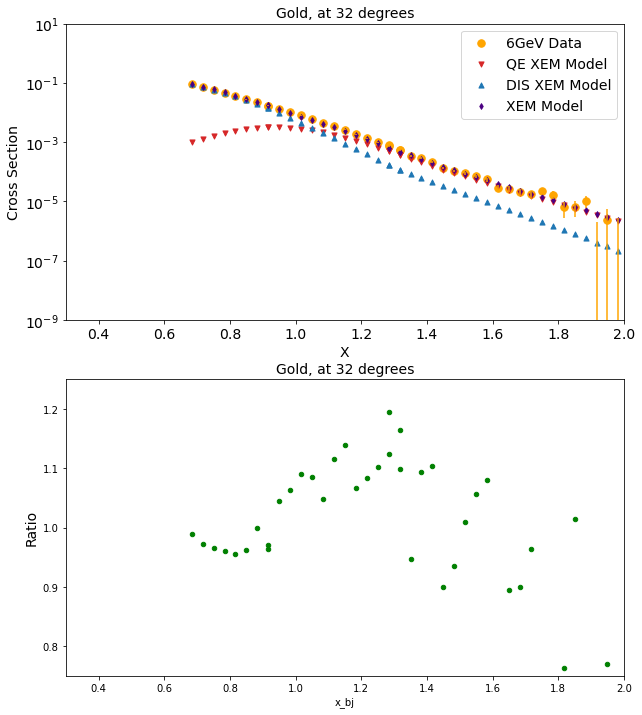

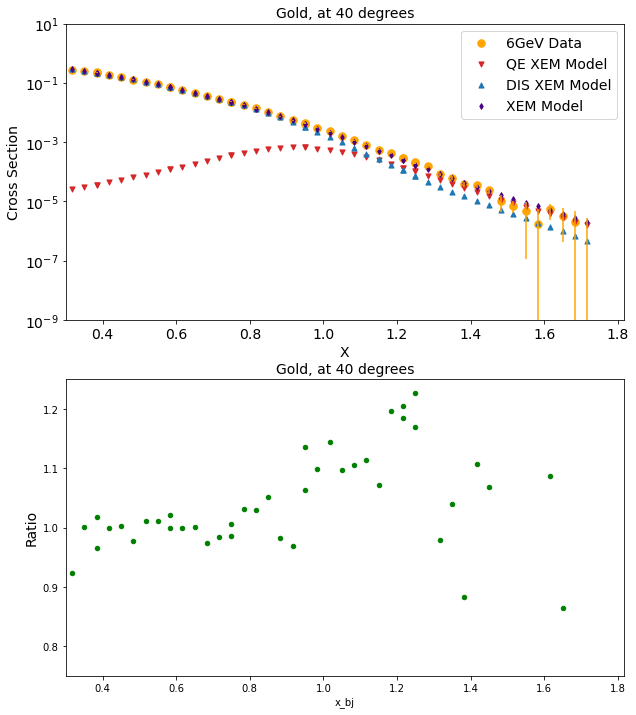

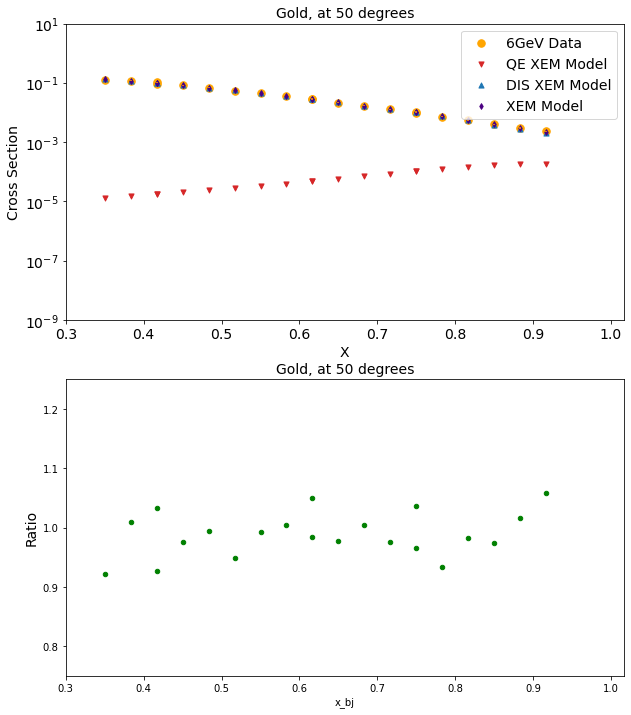

In [14]:
nPlots = len(l_crossSectionsCut)*2
print(nPlots)

for df in l_crossSectionsCut:
    my_plotter(df)